In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import itertools

import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

ModuleNotFoundError: No module named 'tensorflow_decision_forests'

In [3]:
tdf = pd.read_csv('Data\\twitter_training.csv')
vdf = pd.read_csv('Data\\twitter_validation.csv')

In [25]:
TopicList = []
Sentimentlist = []
commentstring = ""

for x in tdf.iterrows():
    TopicList.append(x[1]["Topic"])
    Sentimentlist.append(x[1]["Sentiment"])
    commentstring = commentstring + str(x[1]["Comment"])
    

In [26]:
cTopiclist = Counter(TopicList)
cSentimentlist = Counter(Sentimentlist)
commentwordlist = commentstring.split(" ")
ccommentwordlist = Counter(commentwordlist)

In [ ]:
print(cTopiclist.most_common(10))
print(cSentimentlist.most_common(4))
print(ccommentwordlist.most_common(10))
print(len(set(ccommentwordlist)))

[('Microsoft', 2400), ('TomClancysRainbowSix', 2400), ('MaddenNFL', 2400), ('LeagueOfLegends', 2394), ('CallOfDuty', 2394), ('Verizon', 2382), ('CallOfDutyBlackopsColdWar', 2376), ('ApexLegends', 2376), ('Facebook', 2370), ('Dota2', 2364)]
[('Negative', 22542), ('Positive', 20832), ('Neutral', 18318), ('Irrelevant', 12990)]
[('the', 37674), ('to', 27473), ('and', 24329), ('a', 21657), ('I', 19996), ('of', 18426), ('is', 16295), ('for', 14527), ('/', 14434), ('in', 13791)]
116152


In [29]:
tdf.replace("Irrelevant", "Neutral")

,ID,Topic,Sentiment,Comment
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [ ]:
def Cleaning(x):
    lemmatizer = WordNetLemmatizer()
    x = str(x)
    na = nltk.regexp_tokenize(x.lower(), r'(\b[\w]{2,}\b)')
    naa = []
    for z in na:
        naa.append(lemmatizer.lemmatize(z))
    nnaa = " ".join(naa)
    return nnaa

def RSW(x):
    x = str(x)
    stop_words = set(stopwords.words('english'))
    word_tokens = nltk.regexp_tokenize(x.lower(), r'(\b[\w]{2,}\b)')
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    nt = " ".join(filtered_sentence)
    return nt

#Creating Lem With Stop
for index, row in tdf.iterrows():
    oa = row["Comment"]
    g = row.name
    tdf.loc[g, "clean_Comment"] = Cleaning(oa)

#Creating No Lem With out Stop
for index, row in tdf.iterrows():
    oa = row["Comment"]
    g = row.name
    tdf.loc[g, "No_Stop_Words_Comment"] = RSW(oa)
#Creating Lem With Out Stop
for index, row in tdf.iterrows():
    oa = row["Comment"]
    g = row.name
    ns = Cleaning(oa)
    nns = RSW(ns)
    tdf.loc[g, "No_Stop_Words_Lemmatized_Comment"] = nns
    

ValueError: not enough values to unpack (expected 4, got 2)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(tdf, tdf["Sentiment"], test_size=0.10, random_state=42)

In [71]:
def TheOne(typeofabstract, binary, ngram):
            pipeline = Pipeline([("Vec", CountVectorizer(binary= binary, ngram_range=(1, ngram))), ("Clf", LogisticRegression(max_iter= 3000))])
            scores = cross_validate(pipeline,
                X_train[typeofabstract],
                y_train,
                cv=10, 
                scoring=['f1_macro'])
            pipeline.fit(X_train[typeofabstract], y_train)
            y_true = list(X_test["Comment"])
            y_pred = pipeline.predict(X_test[typeofabstract])
            stufflist = []
            stufflist.append(typeofabstract)
            if binary == True:
                stufflist.append("Binary")
            else:
                stufflist.append("Non-Binary") 
            if ngram == 1:
                stufflist.append("1_ngram") 
            else:
                stufflist.append("2_ngram")
            return metrics.f1_score(y_true, y_pred, average='macro'), scores, stufflist

In [52]:
for index, row in tdf.iterrows():
    if row["Comment"] == float:
        tdf.drop(index)

5548      Neutral
54890     Neutral
30479    Positive
44635     Neutral
16370    Positive
           ...   
37194     Neutral
6265      Neutral
54886    Negative
860      Negative
15795     Neutral
Name: Sentiment, Length: 67213, dtype: object

In [43]:
tdf['Comment'] = tdf['Comment'].astype(str)
tdf['clean_Comment'] = tdf['clean_Comment'].astype(str)
tdf['No_Stop_Words_Comment'] = tdf['No_Stop_Words_Comment'].astype(str)
tdf['No_Stop_Words_Lemmatized_Comment'] = tdf['No_Stop_Words_Lemmatized_Comment'].astype(str)

In [75]:
a, b, c = TheOne("No_Stop_Words_Lemmatized_Comment", False, 1)
a

0.0

In [78]:
test_f1_list = []
cv_f1_list = []
cv_f1t_list = []
event_list = []
a, b, c = TheOne("clean_Comment", True, 1)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("1")
a, b, c = TheOne("No_Stop_Words_Comment", True, 1)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("2")
a, b, c = TheOne("No_Stop_Words_Lemmatized_Comment", True, 1)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("3")
a, b, c = TheOne("Comment", True, 1)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("4")
a, b, c = TheOne("clean_Comment", False, 1)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("5")
a, b, c = TheOne("No_Stop_Words_Comment", False, 1)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("6")
a, b, c = TheOne("No_Stop_Words_Lemmatized_Comment", False, 1)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("7")
a, b, c = TheOne("Comment", False, 1)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("8")
a, b, c = TheOne("clean_Comment", True, 2)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("9")
a, b, c = TheOne("No_Stop_Words_Comment", True, 2)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("10")
a, b, c = TheOne("No_Stop_Words_Lemmatized_Comment", True, 2)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("11")
a, b, c = TheOne("Comment", True, 2)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("12")
a, b, c = TheOne("clean_Comment", False, 2)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("13")
a, b, c = TheOne("No_Stop_Words_Comment", False, 2)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("14")
a, b, c = TheOne("No_Stop_Words_Lemmatized_Comment", False, 2)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("15")
a, b, c = TheOne("Comment", False, 2)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [79]:
ndf = {}
tbl = []
i = 1
for x in range(1, 17):
    ndf[x] = {"Lemmatized" : "", "stop_words" : "", "binarized" : "", "n_gram" : "", "mean_f1" : "", "median_f1" : "", "std_f1" : "", "total_fit_time" : "", "test_f1" : "", "scenario" : ""}
for x in event_list:
    new_list = []
    if "abstract" == x[0]:
        ndf[i]["Lemmatized"] = "Not_Lemmatized"
        ndf[i]["stop_words"] = "Included"
        new_list.append("Not_Lemmatized Stop Words Included")
    elif "clean_abstract" == x[0]:
        ndf[i]["Lemmatized"] = "Is_Lemmatized"
        ndf[i]["stop_words"] = "Included"
        new_list.append("Is_Lemmatized Stop Words Included")
    elif "No_Stop_Words_abstract" == x[0]:
        ndf[i]["Lemmatized"] = "Not_Lemmatized"
        ndf[i]["stop_words"] = "Not_Included"
        new_list.append("Not_Lemmatized Stop Words Not Included")
    else:
        ndf[i]["Lemmatized"] = "Is_Lemmatized"
        ndf[i]["stop_words"] = "Not_Included"
        new_list.append("Is_Lemmatized Stop Words Not Included")
    if x[1] == "Binary":
        ndf[i]["binarized"] = "Yes"
        new_list.append("Is Binarized")
    else:
        ndf[i]["binarized"] = "No"
        new_list.append("Isn't Binarized")
    if x[2] == "1_ngram":
        ndf[i]["n_gram"] = "1"
        new_list.append("Is 1ngram")
    else:
        ndf[i]["n_gram"] = "2"
        new_list.append("Is 2ngram")
    tbl.append(" ".join(new_list))
    ndf[i]["scenario"] = " ".join(new_list)
    i = i + 1
i = 1
for x in test_f1_list:
    ndf[i]["test_f1"] = x
    i = i + 1
i = 1
for x in cv_f1t_list:
    fn = 0
    for y in x:
        fn = y + fn
    ndf[i]["total_fit_time"] = fn
    i = i + 1
i = 1
for x in cv_f1_list:
    ndf[i]["mean_f1"] = np.mean(x)
    i = i + 1
i = 1
for x in cv_f1_list:
    ndf[i]["median_f1"] = np.median(x)
    i = i + 1
i = 1
for x in cv_f1_list:
    ndf[i]["std_f1"] = np.std(x)
    i = i + 1

nndf = pd.DataFrame(ndf)
nndf = pd.DataFrame.transpose(nndf)
display(nndf)
nndf.to_csv('model_card.csv')

,Lemmatized,stop_words,binarized,n_gram,mean_f1,median_f1,std_f1,total_fit_time,test_f1,scenario
1,Is_Lemmatized,Not_Included,Yes,1,0.832681,0.831142,0.005868,31.091416,0.0,Is_Lemmatized Stop Words Not Included Is Binar...
2,Is_Lemmatized,Not_Included,Yes,1,0.839931,0.838872,0.004364,24.956688,0.0,Is_Lemmatized Stop Words Not Included Is Binar...
3,Is_Lemmatized,Not_Included,Yes,1,0.829889,0.829189,0.004636,24.379151,0.0,Is_Lemmatized Stop Words Not Included Is Binar...
4,Is_Lemmatized,Not_Included,Yes,1,0.841382,0.840616,0.004047,33.727923,0.0,Is_Lemmatized Stop Words Not Included Is Binar...
5,Is_Lemmatized,Not_Included,No,1,0.833505,0.831248,0.004708,44.756963,0.0,Is_Lemmatized Stop Words Not Included Isn't Bi...
6,Is_Lemmatized,Not_Included,No,1,0.839821,0.839159,0.003428,35.754926,0.0,Is_Lemmatized Stop Words Not Included Isn't Bi...
7,Is_Lemmatized,Not_Included,No,1,0.831427,0.832321,0.004047,34.312213,0.0,Is_Lemmatized Stop Words Not Included Isn't Bi...
8,Is_Lemmatized,Not_Included,No,1,0.842408,0.841991,0.003539,45.880191,0.0,Is_Lemmatized Stop Words Not Included Isn't Bi...
9,Is_Lemmatized,Not_Included,Yes,2,0.906536,0.907567,0.004067,124.026526,0.0,Is_Lemmatized Stop Words Not Included Is Binar...
10,Is_Lemmatized,Not_Included,Yes,2,0.902423,0.902325,0.004728,96.877957,0.0,Is_Lemmatized Stop Words Not Included Is Binar...


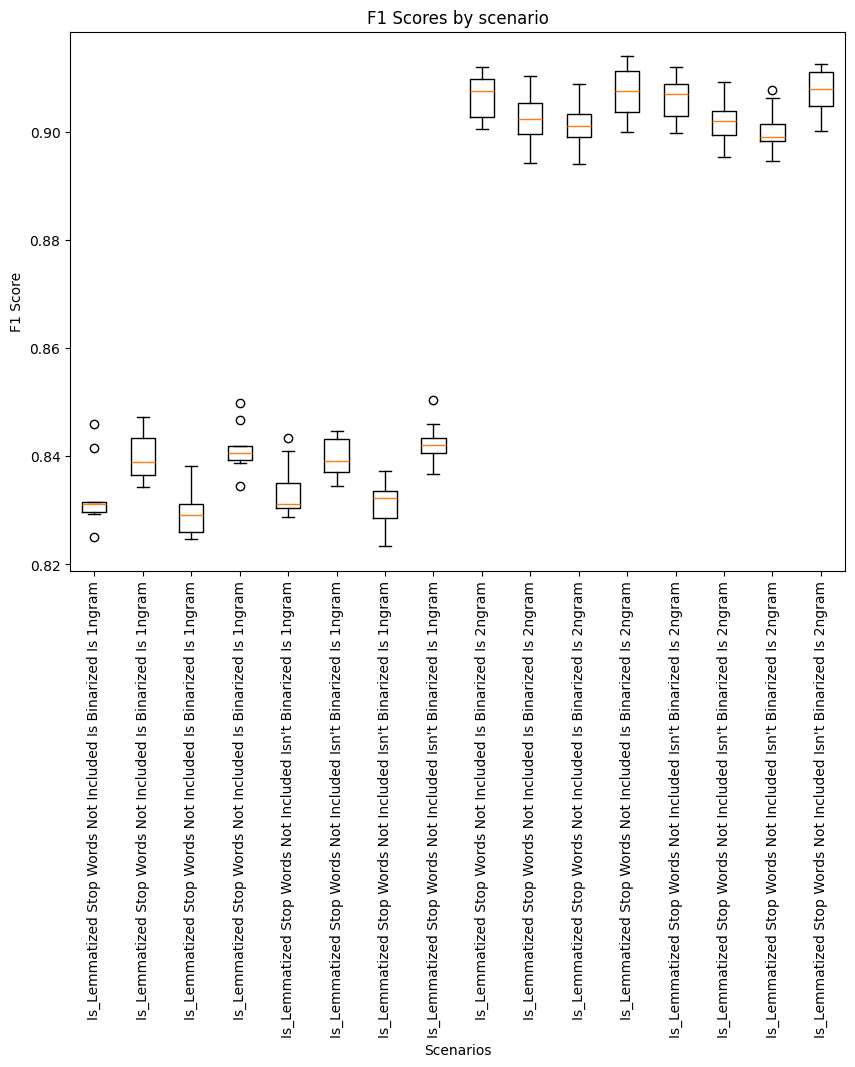

In [81]:
data = []
for x in cv_f1_list:
    
    data.append(x)
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

ax.boxplot(data)
ax.set_xticklabels(tbl, rotation=90)
i = 1

plt.xlabel("Scenarios")
plt.ylabel("F1 Score")
plt.title("F1 Scores by scenario")
plt.show()

In [ ]:
a, b, c = TheOne("No_Stop_Words_Lemmatized_Comment", True, 2)

In [102]:
tdf

,ID,Sentiment,Comment
0,2401,Positive,im getting on borderlands and i will murder yo...
1,2401,Positive,I am coming to the borders and I will kill you...
2,2401,Positive,im getting on borderlands and i will kill you ...
3,2401,Positive,im coming on borderlands and i will murder you...
4,2401,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...
74677,9200,Positive,Just realized that the Windows partition of my...
74678,9200,Positive,Just realized that my Mac window partition is ...
74679,9200,Positive,Just realized the windows partition of my Mac ...
74680,9200,Positive,Just realized between the windows partition of...


In [101]:
tdf = pd.read_csv('Data\\twitter_training.csv')
vdf = pd.read_csv('Data\\twitter_validation.csv')
tdf.drop('Topic', axis=1, inplace=True)

In [107]:
tdf['ID'] = tdf['ID'].astype(str)
tdf['Comment'] = tdf['Comment'].astype(str)

In [108]:
X_train, X_test = train_test_split(tdf, test_size=0.20, random_state=17)
data_dir = Path('data')

X_train['split'] = 'train'
X_test['split'] = 'test'
X = pd.concat([X_train, X_test])
X['path'] = X.apply(lambda x:data_dir.joinpath(x.split, x.Sentiment, x.ID+'.txt'), axis=1)

def save_file(text:str, path: Path):

    if not path.parent.exists():
        path.parent.mkdir(exist_ok=True, parents=True)
    path.write_text(text, encoding='utf-8')

X.apply(lambda x:save_file(x.Comment, x.path), axis=1)

32613    None
42668    None
67985    None
6888     None
22445    None
         ... 
4505     None
642      None
9790     None
73924    None
67805    None
Length: 74682, dtype: object

In [109]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
	'data/train',
    class_names = ['Positive', 'Negative'],
	batch_size=batch_size,
	validation_split=0.2,
	subset='training',
	seed=seed)

Found 7229 files belonging to 2 classes.
Using 5784 files for training.


In [112]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'data/train',
    class_names = ['Positive', 'Negative'],
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
    )

Found 7229 files belonging to 2 classes.
Using 1445 files for validation.


In [114]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'data/test',
    class_names = ['Positive', 'Negative'],
    batch_size=batch_size)

Found 5362 files belonging to 2 classes.


In [120]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [121]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [136]:
train_text

<_MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [122]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [123]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [124]:
AUTOTUNE = tf.data.AUTOTUNE

In [125]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [126]:
embedding_dim = 16

In [145]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dense(30),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [146]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [155]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8845 - loss: 0.2713 - val_binary_accuracy: 0.7571 - val_loss: 0.5562
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8730 - loss: 0.2864 - val_binary_accuracy: 0.7557 - val_loss: 0.5574
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8890 - loss: 0.2620 - val_binary_accuracy: 0.7564 - val_loss: 0.5640
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8913 - loss: 0.2502 - val_binary_accuracy: 0.7529 - val_loss: 0.5710
Epoch 5/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8985 - loss: 0.2445 - val_binary_accuracy: 0.7481 - val_loss: 0.5906
Epoch 6/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8976 - loss: 0.2338 - val_binary_accuracy: 0.7460 - val_loss: 0.6008
Epoch 7/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8944 - loss: 0.2536 - val_binary_accuracy: 0.7433 - val_loss: 0.6095
Epoch 

In [156]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - binary_accuracy: 0.8655 - loss: 0.3524
Loss:  0.35940930247306824
Accuracy:  0.8623647689819336


In [157]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

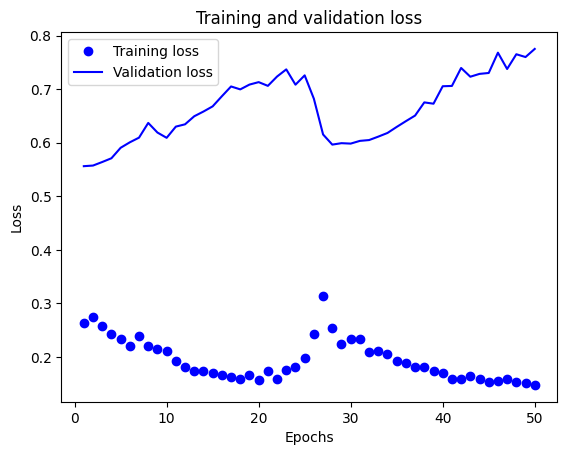

In [158]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
y_pred = (model.predict(test_ds).ravel() > 0.5).astype(int)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


array([0, 0, 0, ..., 1, 1, 0])

In [160]:
def print_metrics(y_true, y_pred, pos_label):

    print(f'Accuracy = {metrics.accuracy_score(y_true, y_pred)}')
    print(f'Recall = {metrics.recall_score(y_true, y_pred, pos_label=pos_label)}')
    print(f'Precision = {metrics.precision_score(y_true, y_pred, pos_label=pos_label)}')
    print(f'F1: {metrics.f1_score(y_true, y_pred, pos_label=pos_label)}')
    print()

    return metrics.f1_score(y_true, y_pred, pos_label=pos_label)

print_metrics(y_true, y_pred, pos_label=1)

Accuracy = 0.8623647892577396
Recall = 0.818900467121811
Precision = 0.9068842021488261
F1: 0.8606495468277946



0.8606495468277946

In [161]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5258 - loss: 0.5659
{'accuracy': 0.5255501866340637, 'loss': 0.566178560256958}


In [177]:
examples = tf.constant([
  "I love people",
  ])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([[0.50527966]], dtype=float32)

In [166]:
predictions = []

for text_batch, label_batch in raw_test_ds:
    print(text_batch.shape)
    for i in range(min(batch_size,text_batch.shape[0])):
        predictions.append((text_batch.numpy()[i], label_batch.numpy()[i], export_model.predict(tf.constant([text_batch.numpy()[i]]))[0][0]))

(32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━

In [167]:
df = pd.DataFrame(predictions, columns=['Comment', 'actual', 'prediction'])